<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_PSD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
bet = 0
samples = 2**15
win_in = 1024
win_ou = 1024
jump = 2**4

dat = cn.powerlaw_psd_gaussian(bet, samples)


In [16]:
data = np.random.normal(0,1,1024)
beta(data)

-0.02177429856893833

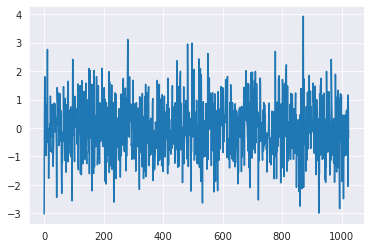

In [17]:
plt.plot(data)

In [21]:
dat[0]

0.13255283482341731

In [28]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
scaler = MaxAbsScaler()
dat = np.reshape(data,(-1, 1))
dat = scaler.fit_transform(dat)



In [31]:
beta(dat)

array([-0.18606622])

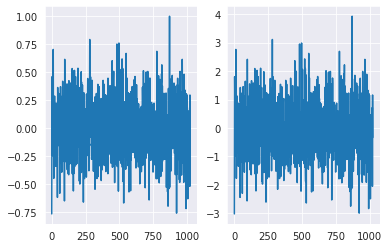

In [29]:
plt.subplot(1,2,1)
plt.plot(dat)

plt.subplot(1,2,2)
plt.plot(data)

#Librarys

In [4]:
!pip install colorednoise
import colorednoise as cn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)
import seaborn as sns
sns.set_style('darkgrid')

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU, RNN,SimpleRNN, InputLayer,Conv1D, add, Reshape, Flatten
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python
import time as time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


$$
Ftt = \sum a_i \sin(2k\pi)+ i b_i \cos(2k\pi)\\
$$
$$
PSD = (a_i + b_i)(a_i-b_i)\\
$$
$$
PSD = a^2 + b^2\\
$$
$$
S_h = {\sum PSD_i \log(PSD_i) \over \log\left(\frac{1}{N}\right)}
$$

were $b$ in the imaginarius parte

# Functions

In [15]:
def entropyShannon(data,norm=True):
  '''
  Calculate the Shannon spectrum entropy for a given dataseta
  '''
  cdata = tf.cast(data,tf.complex128) #tf complex 128 format
  cdata = tf.signal.fft(cdata) #Fast Fourrie Transformation
  cdata = cdata*tf.math.conj(cdata) #PSD Calculation
  cdata = cdata[:len(cdata)//2] #Take only haf
  cdata = cdata/tf.math.reduce_sum(cdata) #Normalização???
  sh = cdata*tf.math.log(cdata) # Calculate Shannon entropy p1
  sh = tf.math.real(tf.math.reduce_sum(sh)) #Calculate Shannon entropy p2
  if norm == True: #Normalize?
    norm = tf.cast(tf.math.log(1.0/tf.cast(len(cdata),tf.float64) ),tf.float64)
    return cdata, sh/norm
  else:
    return cdata, -sh


def fftfreq(n, d=1.0):
    """
    Return the Discrete Fourier Transform sample frequencies.
    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.
    Given a window length `n` and a sample spacing `d`::
      f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd
    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.
    Returns
    -------
    f : ndarray
        Array of length `n` containing the sample frequencies.
    Examples
    --------
    >>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
    >>> fourier = np.fft.fft(signal)
    >>> n = signal.size
    >>> timestep = 0.1
    >>> freq = np.fft.fftfreq(n, d=timestep)
    >>> freq
    array([ 0.  ,  1.25,  2.5 , ..., -3.75, -2.5 , -1.25])
    """
    if not isinstance(n, integer_types):
        raise ValueError("n should be an integer")
    val = 1.0 / (n * d)
    results = empty(n, int)
    N = (n-1)//2 + 1
    p1 = arange(0, N, dtype=int)
    results[:N] = p1
    p2 = arange(-(n//2), 0, dtype=int)
    results[N:] = p2
    return results * val


def beta(data):
  '''
  Calculate de the PSD loglog power law index
  '''
  psd = tf.cast(data,tf.complex128) #tf complex 128 format
  psd = tf.signal.fft(psd) #FFT me da um vetor complexo
  psd = psd*tf.math.conj(psd) #Complexo conjudado 
  #print(len(data))
  freq = np.fft.fftfreq(1024) #mede as frequencias da tranformada de four
  #freq = fftfreq(1024) #mede as frequencias da tranformada de four
  n = len(data)//2 #ponto de conte. Nesse caso é pela metade
  psd = psd[1:n] #Só quero metade dos dados, menos o 1 pq ele estava sendo inf
  freq =  tf.convert_to_tensor(freq[1:n]) #converte para um tensor do tf
  psd = tf.cast(tf.math.log(psd), tf.float64) #convert para log, e só pega o real 
  freq = tf.cast(tf.math.log(freq),tf.float64) #mesma coisa, só que frequencia
  beta, _ =np.polyfit(np.array(freq),np.array(psd),deg=1) #ajuste linear
  return -beta #partiu para o abraço

def diffBeta(y_true, y_pred):
  return (beta(y_true)-beta(y_pred))**2

def create_dataset(dataset, window_in=10,window_ou=10,window_next=1):
	'''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  window_next will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
	dataset = dataset.reshape(len(dataset),1)
	dataX, dataY = [], []
	for i in range(0,len(dataset)-window_in-window_ou+1,window_next):
		dataX.append(dataset[i:(i+window_in), 0])
		dataY.append(dataset[i + window_in:i + window_in + window_ou, 0])
	return np.array(dataX), np.array(dataY)  

def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_)
  plt.plot(y2)
  #plt.show() 

# Data

## Data Download

In [ ]:
#Monting Google Drive
#https://medium.com/analyatics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#Unziping data-set
!unzip "synthetic-colored-noise.zip" -d "/content/"

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
synthetic-colored-noise.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  synthetic-colored-noise.zip
  inflating: /content/color.csv      
  inflating: /content/color.plk      
  inflating: /content/color_4series.plk  


In [ ]:
# #Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


In [ ]:
import pandas as pd 
df = pd.read_pickle('color_4series.plk')

In [ ]:
serie_index = 0  #white Noise
#serie_index = 4 #pink noise
#serie_index =  9#red Noise

min_size , max_size = 0 , len(df.Series[0])

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values.astype('float32')

## Data Generations 

In [38]:
dat = cn.powerlaw_psd_gaussian(bet, samples)
scaler = MaxAbsScaler()
dat1 = np.reshape(dat,(-1, 1))
dat1 = scaler.fit_transform(dat1)


In [51]:
dat2 = np.reshape(dat1,len(dat1))
print(dat2.shape,dat.shape)

(32768,) (32768,)


## Create Dataset

In [34]:
bet = 0
samples = 2**15
win_in = 1024
win_ou = 1024
jump = 2**4

dataset = dat

trainX,trainY = create_dataset(dataset,win_in,win_ou,jump)


In [35]:
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1],1)
#trainY = trainY.reshape(np.axi,trainY.shape[1],trainY.shape[0])

IndexError: ignored

In [ ]:
trainX.shape

(1921, 1024, 1)

# Model

In [ ]:
#Paramenters 
epochs = 3
batch_size = 256#len(trainX)# 256#
model_code = 'test'#All_layers_Bacth256'
n_1 = 64#10#int(look_back*100)
n_2 = 64#int(look_back*100)
n_3 = 64 #int(look_back*1e-1)
n_4 = 64#10#int(look_back*1e-1)

In [ ]:
def beta3(data):
  '''
  Calculate de the PSD loglog power law index
  '''
  psd = tf.cast(data,tf.complex128) #tf complex 128 format
  psd = tf.signal.fft(psd) #FFT me da um vetor complexo
  psd = psd*tf.math.conj(psd) #Complexo conjudado 
  #print(len(data))
  timestep = 0.1
  freq = np.fft.fftfreq(len(data))#, d = timestep)
  return freq

In [ ]:
signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
fourier = np.fft.fft(signal)
n = signal.size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
print(signal)
print(freq)

[-2.  8.  6.  4.  1.  0.  3.  5.]
[ 0.    1.25  2.5   3.75 -5.   -3.75 -2.5  -1.25]


In [ ]:
tf.signal.fft(signal)

<tf.Tensor: shape=(8,), dtype=complex64, numpy=
array([ 25.       +0.j       ,   3.3639607-7.9497476j,
       -10.       +1.j       ,  -9.36396  -1.9497476j,
        -9.       +0.j       ,  -9.36396  +1.9497476j,
       -10.       -1.j       ,   3.3639607+7.9497476j], dtype=complex64)>

In [ ]:
beta3(signal)

array([ 0.  ,  1.25,  2.5 ,  3.75, -5.  , -3.75, -2.5 , -1.25])

In [ ]:

beta3(signal)

array([ 0.   ,  0.125,  0.25 ,  0.375, -0.5  , -0.375, -0.25 , -0.125])

In [ ]:
#https://cnvrg.io/keras-custom-loss-functions/
import keras
import numpy as np
from tensorflow.python.ops import math_ops

def custom_loss(y_true, y_pred):
  # def beta2(data):
  #   '''
  #   Calculate de the PSD loglog power law index
  #   '''
  #   psd = tf.cast(data,tf.complex128) #tf complex 128 format
  #   psd = tf.signal.fft(psd) #FFT me da um vetor complexo
  #   psd = psd*tf.math.conj(psd) #Complexo conjudado 
  #   #print(len(data))
  #   freq = np.fft.fftfreq(1024) #mede as frequencias da tranformada de four
  #   #freq = fftfreq(1024) #mede as frequencias da tranformada de four
  #   n = len(data)//2 #ponto de conte. Nesse caso é pela metade
  #   psd = psd[1:n] #Só quero metade dos dados, menos o 1 pq ele estava sendo inf
  #   freq =  tf.convert_to_tensor(freq[1:n]) #converte para um tensor do tf
  #   psd = tf.cast(tf.math.log(psd), tf.float64) #convert para log, e só pega o real 
  #   freq = tf.cast(tf.math.log(freq),tf.float64) #mesma coisa, só que frequencia
  #   beta, _ =np.polyfit(np.array(freq),np.array(psd),deg=1) #ajuste linear
  #   beta = -beta #partiu para o abraço
 diff = math_ops.squared_difference(beta(y_pred), beta(y_true))  #squared difference
 #loss = K.mean(diff, axis=-1) #mean over last dimension
 return diff

In [ ]:
teste = tf.reshape(res,0)

InvalidArgumentError: ignored

In [ ]:
tf.shape(res)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [ ]:
y_true = [[0., 1.,3,5], [0., 0.,3,5,6]]
y_pred = [[1., 1.,3,2], [1., 0.,3,5,6]]
# Using 'auto'/'sum_over_batch_size' reduction type.
#mae = tf.keras.losses.MeanAbsoluteError()
res = custom_loss(trainX[0], pred[0])
res.shape

TensorShape([1])

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
res = custom_loss(trainX[0], pred[0])

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.00342158])>>

1024

In [ ]:
tf.math.subtract([2,3],[2.1,2.9])

TypeError: ignored

In [ ]:
tf.compat.v1.enable_eager_execution()

star_RNN = time.time()
model_RNN = Sequential()
model_RNN.add(SimpleRNN(n_1, return_sequences=True,input_shape=[win_in,1] ))
model_RNN.add(SimpleRNN(n_4))
model_RNN.add(Dense(win_ou))
model_RNN.compile(loss=custom_loss, optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)

Epoch 1/3


TypeError: ignored

In [ ]:
pred = model_RNN.predict(trainX[0])

In [ ]:
pred[0].shape

(1024,)

In [ ]:
type(beta(pred[k]))

numpy.float64

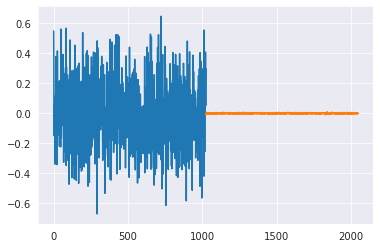

In [ ]:
k = 2
plot_test(trainX[k],pred[k])